# Obama & The Onion: An Analysis

This notebook contains analysis of every story The Onion wrote about Obama during his presidency, as determined by their  [_Black Man Does 8 Years_](https://www.theonion.com/interactive/obama) feature.



In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm, metrics
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
# plot inline
%matplotlib inline

In [2]:
# increase default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [3]:
# always be stylish
plt.style.use('ggplot')

## Rudimentary EDA

In [4]:
# load data
obama = pd.read_csv('obama_scraped.csv')

In [5]:
obama.head()

,Unnamed: 0,link,title,date,tag0,tag1,tag2,tag3,tag4,body
0,0,http://theonion.com/article/black-guy-asks-nat...,Black Guy Asks Nation For Change\n,"March 19, 2008",Politics,Politicians,Presidents,Campaigns,NaN,"[CHICAGO—According to witnesses, a loud black ..."
1,1,http://theonion.com/article/obama-clinton-mcca...,"Obama, Clinton, McCain Join Forces To Form Nig...","May 21, 2008",Politics,War For The White House,Hillary Clinton,John Mccain,Barack Obama,[WASHINGTON—Presidential hopefuls John McCain ...
2,2,http://theonion.com/article/obama-practices-lo...,Obama Practices Looking-Off-Into-Future Pose\n,"May 28, 2008",Politics,War For The White House,Barack Obama,NaN,NaN,[CHICAGO—As the 2008 presidential election dra...
3,3,http://theonion.com/article/time-publishes-def...,'Time' Publishes Definitive Obama Puff Piece\n,"July 18, 2008",Politics,War For The White House,Barack Obama,NaN,NaN,[NEW YORK—Hailed by media critics as the fluff...
4,4,http://theonion.com/article/obamas-hillbilly-h...,Obama's Hillbilly Half-Brother Threatening To ...,"August 13, 2008",Politics,Family,Presidents,Rural,War For The White House,"[BOONEVILLE, KY—Barack Obama's once-commanding..."


In [6]:
# drop pesky unnamed column
obama.drop('Unnamed: 0', axis=1, inplace=True)

In [7]:
# set date columns to datetime object
obama['date'] = pd.to_datetime(obama['date'])

In [8]:
# check unique story content tags
print pd.concat([obama['tag0'], obama['tag1'], obama['tag2'], obama['tag3'], obama['tag4']]).nunique()
pd.concat([obama['tag0'], obama['tag1'], obama['tag2'], obama['tag3'], obama['tag4']]).unique()

89


array(['Politics', 'War For The White House', 'Sports', 'Crime & Justice',
       'Survival', 'Health', 'Jobs', 'Family', 'Economy', 'Barack Obama',
       'Revenge', 'News', 'Politicians', 'Opinion', 'Our Annual Year 2012',
       nan, 'Animals', 'Science & Technology', 'Business', 'Violence',
       'World', 'Entertainment', 'Death', 'Environment',
       'Self-Improvement', 'Time Travel', 'Ecstasy Of Defeat', 'Comics',
       'Elections', 'John Mccain', 'Disasters', 'Senior Citizens', 'War',
       'Healthcare', 'Basketball', 'Natural Disasters',
       'Our Annual Year 2011', 'Gay & Lesbian', 'Presidents',
       'Unsponsored', 'College Basketball', 'Iran', 'Human Interest',
       'Our Annual Year 2013', 'Football', 'Sex', 'Government', 'Fitness',
       'Terrorism', 'Police', 'Education', 'Guns', 'College',
       'World Leaders', 'Supreme Court', 'Movies', 'Pets',
       'Hillary Clinton', 'Voting', 'Electronics', 'Tom Vilsack',
       'Yu Wan Mei', 'Military', 'Music', 'Ifc', '

In [9]:
# how many of each content tag?
pd.concat([obama['tag0'], obama['tag1'], obama['tag2'], obama['tag3'], obama['tag4']]).value_counts()

Politics                   190
Barack Obama               189
Politicians                108
News                        45
War For The White House     29
Government                  11
Our Annual Year 2012        10
Opinion                      9
War                          8
Our Annual Year 2013         8
Healthcare                   7
Presidents                   7
Our Annual Year 2011         7
World Leaders                7
World                        6
Economy                      5
Sports                       5
Violence                     4
Guns                         4
Family                       4
Syria                        4
Health                       3
Isis                         3
Hillary Clinton              3
Foreign Policy               3
Lifestyle                    3
Military                     3
Terrorism                    3
Unsponsored                  2
Mitt Romney                  2
                          ... 
Supreme Court                1
Human In

In [10]:
# what percent of the total are in the top 10 story tags?
float((pd.concat([obama['tag0'], obama['tag1'], obama['tag2'], obama['tag3'], obama['tag4']]).value_counts()[0:10]).sum())/(pd.concat([obama['tag0'], obama['tag1'], obama['tag2'], obama['tag3'], obama['tag4']]).value_counts().sum())*100

79.03645833333334

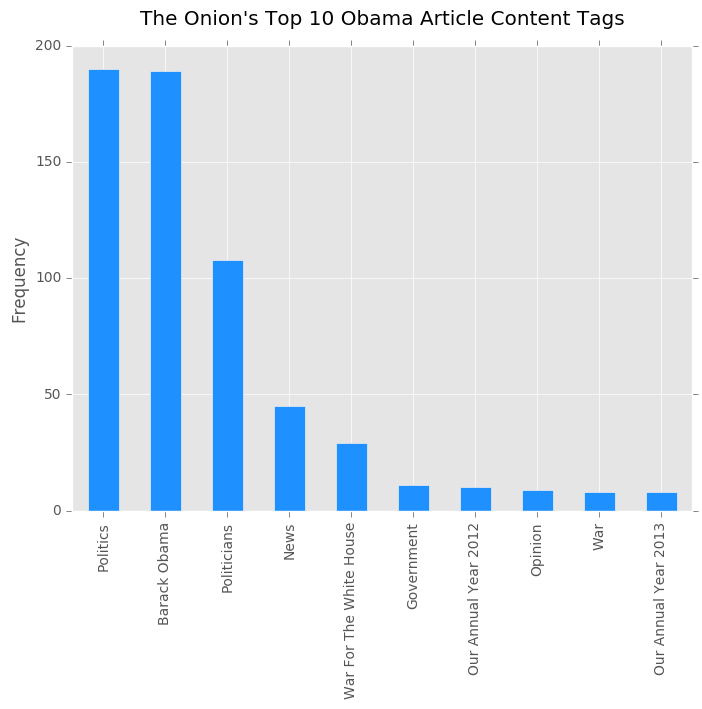

In [11]:
# top 10 most common story content tags
pd.concat([obama['tag0'], obama['tag1'], obama['tag2'], obama['tag3'], obama['tag4']]).value_counts().nlargest(10).plot(kind='bar', color='dodgerblue')
# plt.xlabel('Content Tag')
plt.title("The Onion's Top 10 Obama Article Content Tags",  y=1.03)
plt.ylabel('Frequency')
plt.savefig('./graphs/top-content-tags.png', dpi=300, bbox_inches='tight')
# plt.savefig('output.png', dpi=300)

## Time Series

In [12]:
# plot stories over time
ts = obama.set_index('date')

In [13]:
# columns?
obama.columns

Index([u'link', u'title', u'date', u'tag0', u'tag1', u'tag2', u'tag3', u'tag4',
       u'body'],
      dtype='object')

In [14]:
ts['Total'] = obama.index+1

In [15]:
# define a function to obtain story length
def get_length(text):
    return len(text)

In [16]:
# create the column for length
ts['length'] = ts.body.apply(get_length)

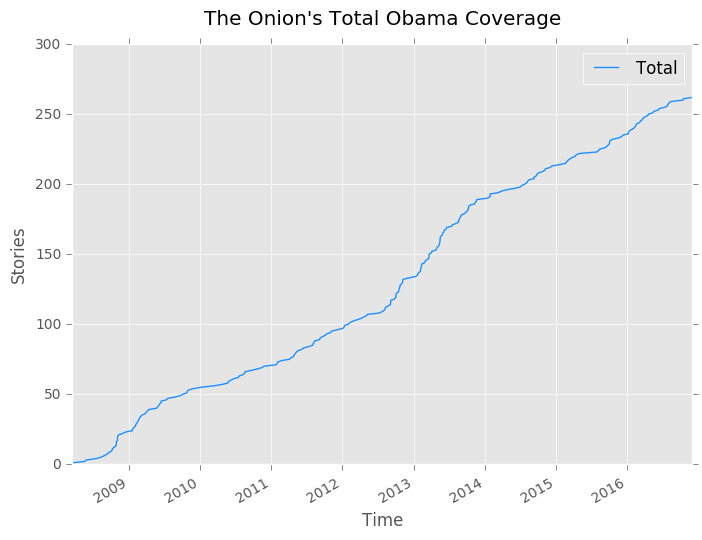

In [17]:
# plot it
ts.drop('length', axis=1).plot(color='dodgerblue')
plt.title("The Onion's Total Obama Coverage",  y=1.03)
plt.xlabel('Time')
plt.ylabel('Stories')
plt.savefig('./graphs/total-coverage.png', dpi=300, bbox_inches='tight')

In [18]:
# Q: what drove the increase in late 2012 - early 2013? A: 2012 election, misc Obama 2013 early stories
ts['2012-03-01':'2014-01-01']

,link,title,tag0,tag1,tag2,tag3,tag4,body,Total,length
date,,,,,,,,,,
2012-03-13,http://theonion.com/article/obama-waiting-for-...,Obama Waiting For Perfect Moment To Walk By Wh...,Politicians,Barack Obama,Our Annual Year 2012,NaN,NaN,"[WASHINGTON—According to White House sources, ...",103,1013
2012-04-04,http://theonion.com/article/backup-health-care...,Backup Health Care Plan Involves Nation Sharin...,Politics,Healthcare,Our Annual Year 2012,NaN,NaN,[WASHINGTON—In the event the Supreme Court str...,104,1225
2012-04-18,http://theonion.com/article/obama-launches-mor...,Obama Launches More Realistic 'I Have Big Idea...,Politics,War For The White House,Barack Obama,Our Annual Year 2012,NaN,[CHICAGO—After coming to terms with the limite...,105,4219
2012-05-03,http://theonion.com/article/obama-asks-staff-t...,Obama Asks Staff To Try To Include National Se...,News,Human Interest,Politicians,Barack Obama,NaN,"[WASHINGTON—According to White House sources, ...",106,3363
2012-05-09,http://theonion.com/article/obama-blasts-obama...,Obama Blasts Obama's Evasive Stance On Gay Mar...,Politics,Politicians,Gay & Lesbian,Barack Obama,Our Annual Year 2012,[WASHINGTON—President Barack Obama lashed out ...,107,3813
2012-07-10,http://theonion.com/article/obama-pledges-to-r...,Obama Pledges To Repeal Health Care Law If Ree...,Politics,Politicians,War For The White House,Barack Obama,NaN,"[WASHINGTON—Calling it a ""poorly conceived and...",108,2285
2012-07-24,http://theonion.com/blogpost/holy-shit-i-just-...,"Holy Shit, I Just Realized People Want To Kill...",Opinion,NaN,NaN,NaN,NaN,[I've always known my father was an important ...,109,4095
2012-08-03,http://theonion.com/article/area-family-awakes...,Area Family Awakes To Find Michelle Obama Tend...,News,NaN,NaN,NaN,NaN,"[HENNIKER, NH—Sources within the Cafferty hous...",110,842
2012-08-09,http://theonion.com/article/now-that-man-has-h...,"Now That Man Has Heard About Barack Obama, He ...",Our Annual Year 2012,NaN,NaN,NaN,NaN,"[WEST LEBANON, NH—After first learning of Bara...",111,808


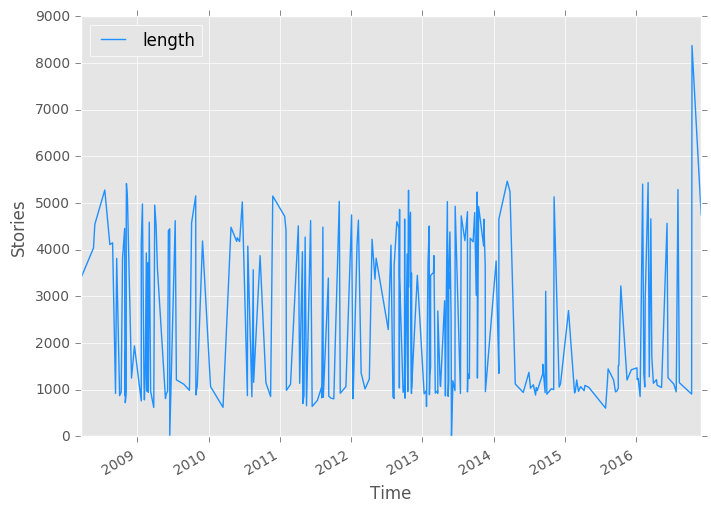

In [19]:
# plot story length over time
ts.plot(x=ts.index, y='length', color='dodgerblue')
plt.xlabel('Time')
plt.ylabel('Stories')

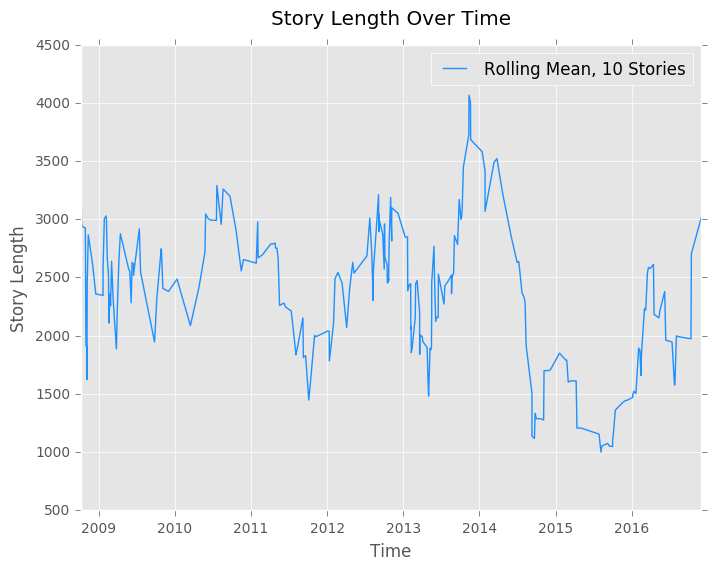

In [20]:
# let's plot a rolling mean instead; the above is too noisey
fig = plt.figure(figsize=(8, 6))
plt.plot(ts.length.rolling(window=10,center=False).mean(), label='Rolling Mean, 10 Stories', color='dodgerblue')
plt.legend(loc='best')
plt.title('Story Length Over Time', y=1.03)
plt.ylabel('Story Length')
plt.xlabel('Time')
plt.savefig('./graphs/story-length-rolling-average.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
# Q: what caused the big spike in length in late 2013? A: Syria, lifestyle stories
ts['2013-06-01':'2014-01-01']

,link,title,tag0,tag1,tag2,tag3,tag4,body,Total,length
date,,,,,,,,,,
2013-06-05,http://theonion.com/article/obama-takes-excite...,Obama Takes Excited Daughters Out For Day Of D...,News,Politicians,Barack Obama,Our Annual Year 2013,NaN,"[WANA, PAKISTAN—Calling it a chance to get som...",166,922
2013-06-06,http://theonion.com/article/obama-administrati...,Obama Administration Releases Nation’s Phone R...,Politics,Politicians,Barack Obama,NaN,NaN,[WASHINGTON—On the heels of reports that the N...,167,1188
2013-06-17,http://theonion.com/article/michelle-obama-see...,Michelle Obama Seen Outside Walking Family Rhi...,News,Animals,Politicians,Our Annual Year 2013,NaN,[WASHINGTON—Spectators outside the White House...,168,977
2013-06-18,http://theonion.com/blogpost/sometimes-when-th...,"Sometimes When Things Get Really Stressful, I ...",Barack Obama,Opinion,NaN,NaN,NaN,[Leading the greatest country in the world is ...,169,4927
2013-07-15,http://theonion.com/article/michelle-obama-fin...,Michelle Obama Finally Gets Around To Reading ...,Politics,Politicians,Barack Obama,NaN,NaN,[WASHINGTON—Saying that she had put it off for...,170,916
2013-07-19,http://theonion.com/article/tiny-advisor-who-l...,Tiny Advisor Who Lived In Obama’s Ear Dead At ...,Politics,Politicians,Barack Obama,Our Annual Year 2013,Breaking,"[WASHINGTON—Robert Linder, a miniature man who...",171,4721
2013-08-07,http://theonion.com/article/obama-not-sure-how...,"Obama Not Sure How To Tell Nation This, But He...",News,Politics,Transportation,Barack Obama,Our Annual Year 2013,"[WASHINGTON—Sighing and shaking his head, a sh...",172,4190
2013-08-20,http://theonion.com/article/psychiatrist-patie...,Psychiatrist Patiently Listens To Obama Compla...,Politics,Politicians,Barack Obama,NaN,NaN,[WASHINGTON—Carefully jotting down notes as th...,173,4812
2013-08-20,http://theonion.com/article/obama-family-adopt...,Obama Family Adopts 44-Year-Old Portuguese Wat...,News,Barack Obama,NaN,NaN,NaN,[WASHINGTON—Providing a friendly playmate for ...,174,951


## Text Processing

In [22]:
# grab only text
text = obama.body

In [23]:
# check it out
print(text[0:5])

0    [CHICAGO—According to witnesses, a loud black ...
1    [WASHINGTON—Presidential hopefuls John McCain ...
2    [CHICAGO—As the 2008 presidential election dra...
3    [NEW YORK—Hailed by media critics as the fluff...
4    [BOONEVILLE, KY—Barack Obama's once-commanding...
Name: body, dtype: object


In [24]:
# create function to grab location
def get_location(text):
    location, sep, body = text.partition('—')
    if len(location) > 100:
        return np.nan
    else:
        return location[1:]

In [25]:
# create location column
obama['location'] = obama.body.apply(get_location)

In [26]:
# create function to get body text without location
def get_body(text):
    if '—' in text[0:50]:
        location, sep, body = text.partition('—')
        if len(location) > 100:
            pass
        else:
            return body
    else:
        return text

In [27]:
# replace old body with new location-less body
obama['body'] = obama.body.apply(get_body)

In [28]:
# examine new df
obama.head(20)

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
0,http://theonion.com/article/black-guy-asks-nat...,Black Guy Asks Nation For Change\n,2008-03-19,Politics,Politicians,Presidents,Campaigns,NaN,"According to witnesses, a loud black man appro...",CHICAGO
1,http://theonion.com/article/obama-clinton-mcca...,"Obama, Clinton, McCain Join Forces To Form Nig...",2008-05-21,Politics,War For The White House,Hillary Clinton,John Mccain,Barack Obama,"Presidential hopefuls John McCain (R-AZ), Bara...",WASHINGTON
2,http://theonion.com/article/obama-practices-lo...,Obama Practices Looking-Off-Into-Future Pose\n,2008-05-28,Politics,War For The White House,Barack Obama,NaN,NaN,As the 2008 presidential election draws closer...,CHICAGO
3,http://theonion.com/article/time-publishes-def...,'Time' Publishes Definitive Obama Puff Piece\n,2008-07-18,Politics,War For The White House,Barack Obama,NaN,NaN,"Hailed by media critics as the fluffiest, most...",NEW YORK
4,http://theonion.com/article/obamas-hillbilly-h...,Obama's Hillbilly Half-Brother Threatening To ...,2008-08-13,Politics,Family,Presidents,Rural,War For The White House,Barack Obama's once-commanding lead in the pol...,"BOONEVILLE, KY"
5,http://theonion.com/article/obama-modifies-yes...,Obama Modifies 'Yes We Can' Message To Exclude...,2008-08-27,Politics,Self-Improvement,Elections,War For The White House,Barack Obama,"In a nationally televised speech Friday, Democ...","COLUMBIA, SC"
6,http://theonion.com/article/obama-suddenly-pan...,Obama Suddenly Panicked After Gazing Too Far I...,2008-09-11,Politics,Time Travel,War For The White House,Barack Obama,NaN,Sen. Barack Obama (D-IL) fell deathly silent i...,"MADISON, WI"
7,http://theonion.com/article/obama-deletes-anot...,Obama Deletes Another Unread MoveOn.org E-Mail\n,2008-09-17,Politics,War For The White House,Barack Obama,NaN,NaN,After receiving yet another unwanted e-mail fr...,CHICAGO
8,http://theonion.com/article/parents-of-obama-v...,Parents Of Obama Volunteer Couldn't Be More Pr...,2008-10-02,Politics,War For The White House,Barack Obama,NaN,NaN,Parents of Obama '08 campaign volunteer Mark L...,"OAK PARK, IL"
9,http://theonion.com/article/obama-clinches-joe...,Obama Clinches 'Joe Cabernet Sauvignon' Vote\n,2008-10-08,War For The White House,Barack Obama,NaN,NaN,NaN,Following a strong performance by the Democrat...,WASHINGTON


In [29]:
# not bad, Mr Location Function.
obama.isnull().sum()

link          0
title         0
date          0
tag0          2
tag1         28
tag2         95
tag3        186
tag4        231
body          0
location     11
dtype: int64

In [30]:
# list all locations
obama.location.unique()

array(['CHICAGO', 'WASHINGTON', 'NEW YORK', 'BOONEVILLE, KY',
       'COLUMBIA, SC', 'MADISON, WI', 'OAK PARK, IL', 'FOXWORTH, MS',
       'TALLAHASSEE, FL', 'BURBANK, CA', 'INDIANAPOLIS', 'LOS ANGELES',
       'HUTCHINSON, KS', 'ATHENS, GA', 'VAVUNIYA, SRI LANKA', 'PHOENIX',
       ']', nan, 'KABUL, AFGHANISTAN', 'MIAMI', 'ROCKLAND, ME',
       'NEW ORLEANS', 'CAMP SPRINGS, MD', 'HARTFORD, CT', 'KALONA, IA',
       'GRAND RAPIDS, MI', 'CINCINNATI', 'PITTSBURGH', 'HENNIKER, NH',
       'WEST LEBANON, NH', 'NEW BRITAIN, CT', 'COVINGTON, KY',
       'CHARLOTTE, NC', 'CHARLESTON, WV', 'COLUMBUS, OH',
       'EVERYWHERE IN SPACE-TIME SIMULTANEOUSLY', 'DENVER',
       'HEMPSTEAD, NY', 'PARMA, OH', 'BOCA RATON, FL', 'WOOFINGTON, D.C.',
       'TEL AVIV, ISRAEL', 'JERUSALEM', 'DALLAS', 'CORTLAND, NY',
       'WANA, PAKISTAN', 'SEATTLE', 'WALTHAM, MA', 'SEDALIA, MO', 'HAVANA',
       'BAY LAKE, FL', 'PHILADELPHIA', 'THURMONT, MD', 'GARDINER, MT',
       'CEDAR PLAINS, PA'], dtype=object)

In [31]:
# identify top locations, calc what percent is the single top location
print (float((obama.location.value_counts()[0]))/(obama.location.value_counts().sum()))*100
obama.location.value_counts()

72.5099601594


WASHINGTON                                 182
CHICAGO                                      7
JERUSALEM                                    3
NEW YORK                                     3
BOCA RATON, FL                               2
PHILADELPHIA                                 2
COLUMBIA, SC                                 2
CHARLOTTE, NC                                2
DENVER                                       2
]                                            2
ROCKLAND, ME                                 1
BURBANK, CA                                  1
CORTLAND, NY                                 1
LOS ANGELES                                  1
KALONA, IA                                   1
WOOFINGTON, D.C.                             1
CHARLESTON, WV                               1
OAK PARK, IL                                 1
EVERYWHERE IN SPACE-TIME SIMULTANEOUSLY      1
WANA, PAKISTAN                               1
BAY LAKE, FL                                 1
ATHENS, GA   

Locations follow relatively what we'd expect: overwhelmingly in DC, some missing values, and in Chicago's hometown.

Let's check out some of the bizarre locations...

In [32]:
# space?
obama[obama.location=='EVERYWHERE IN SPACE-TIME SIMULTANEOUSLY']

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
119,http://theonion.com/article/obama-makes-surpri...,Obama Makes Surprise Visit To Quantum-Branchin...,2012-10-02,Politics,Politicians,Barack Obama,NaN,NaN,Attempting to appeal to the widest possible de...,EVERYWHERE IN SPACE-TIME SIMULTANEOUSLY


<img src="story-screenshots/obama-quantum.png">

[source](http://www.theonion.com/article/obama-makes-surprise-visit-to-quantum-branching-mu-29763)

In [33]:
# Pakistan?
obama[obama.location=='WANA, PAKISTAN']

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
165,http://theonion.com/article/obama-takes-excite...,Obama Takes Excited Daughters Out For Day Of D...,2013-06-05,News,Politicians,Barack Obama,Our Annual Year 2013,NaN,Calling it a chance to get some fresh air and ...,"WANA, PAKISTAN"


<img src="story-screenshots/obama-pakistan.png">

[source](http://www.theonion.com/article/obama-takes-excited-daughters-out-for-day-of-drone-32702)

In [34]:
# like I was going to check Iowa
obama[obama.location=='KALONA, IA']

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
82,http://theonion.com/article/obamas-aunt-sends-...,Obama's Aunt Sends Him Article Mentioning Unit...,2011-06-16,Family,NaN,NaN,NaN,NaN,"According to family sources, Barack Obama's au...","KALONA, IA"


<img src="story-screenshots/obama-iowa.png">

[source](http://www.theonion.com/article/obamas-aunt-sends-him-article-mentioning-united-st-20734)

In [35]:
# The Onion like to hit Obama on (a lack of) Israel visits...
obama[obama.location=='JERUSALEM']

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
147,http://theonion.com/article/obama-sarcasticall...,Obama Sarcastically Asks How Israel Afforded S...,2013-03-20,Politics,Politicians,Foreign Policy,Barack Obama,NaN,While touring Israel’s “Iron Dome” all-weather...,JERUSALEM
148,http://theonion.com/article/obama-rachel-golds...,"Obama, Rachel Goldstein Really Hitting It Off ...",2013-03-21,Politics,Politicians,NaN,NaN,NaN,Participants on Taglit Shorashim’s Israel Expe...,JERUSALEM
149,http://theonion.com/article/palestinians-israe...,"Palestinians, Israelis Come Together To Mock O...",2013-03-21,Politics,World,World Leaders,NaN,NaN,Coming together for the first time in generati...,JERUSALEM


I screenshotted the third story.
<img src="story-screenshots/obama-jerusalem3.png">

[source](http://www.theonion.com/article/palestinians-israelis-come-together-to-mock-obamas-31767)

First Jerusalem story [here](http://www.theonion.com/article/obama-sarcastically-asks-how-israel-afforded-such--31750) and second Jerusalem story [here](http://www.theonion.com/article/obama-rachel-goldstein-really-hitting-it-off-on-gr-31753)

In [36]:
# Afghanistan
obama[obama.location=='KABUL, AFGHANISTAN']  

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
50,http://theonion.com/article/us-continues-quagm...,U.S. Continues Quagmire-Building Effort In Afg...,2009-10-27,Politics,War,Military,NaN,NaN,"According to sources at the Pentagon, America...","KABUL, AFGHANISTAN"


<img src="story-screenshots/obama-afghanistan.png">

[source](http://www.theonion.com/article/us-continues-quagmire-building-effort-in-afghanist-2837)

In [37]:
obama.head()

,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location
0,http://theonion.com/article/black-guy-asks-nat...,Black Guy Asks Nation For Change\n,2008-03-19,Politics,Politicians,Presidents,Campaigns,NaN,"According to witnesses, a loud black man appro...",CHICAGO
1,http://theonion.com/article/obama-clinton-mcca...,"Obama, Clinton, McCain Join Forces To Form Nig...",2008-05-21,Politics,War For The White House,Hillary Clinton,John Mccain,Barack Obama,"Presidential hopefuls John McCain (R-AZ), Bara...",WASHINGTON
2,http://theonion.com/article/obama-practices-lo...,Obama Practices Looking-Off-Into-Future Pose\n,2008-05-28,Politics,War For The White House,Barack Obama,NaN,NaN,As the 2008 presidential election draws closer...,CHICAGO
3,http://theonion.com/article/time-publishes-def...,'Time' Publishes Definitive Obama Puff Piece\n,2008-07-18,Politics,War For The White House,Barack Obama,NaN,NaN,"Hailed by media critics as the fluffiest, most...",NEW YORK
4,http://theonion.com/article/obamas-hillbilly-h...,Obama's Hillbilly Half-Brother Threatening To ...,2008-08-13,Politics,Family,Presidents,Rural,War For The White House,Barack Obama's once-commanding lead in the pol...,"BOONEVILLE, KY"


In [38]:
# grab location-free text
text = obama.body

In [39]:
# check it out
text[0:5]

0    According to witnesses, a loud black man appro...
1    Presidential hopefuls John McCain (R-AZ), Bara...
2    As the 2008 presidential election draws closer...
3    Hailed by media critics as the fluffiest, most...
4    Barack Obama's once-commanding lead in the pol...
Name: body, dtype: object

In [40]:
# investigate single entry
text[0]

'According to witnesses, a loud black man approached a crowd of some 4,000 strangers in downtown Chicago Tuesday and made repeated demands for change., "The time for change is now," said the black guy, yelling at everyone within earshot for 20 straight minutes, practically begging America for change. "The need for change is stronger and more urgent than ever before. And only you\xe2\x80\x94the people standing here today, and indeed all the people of this great nation\xe2\x80\x94only you can deliver this change.", It is estimated that, to date, the black man has asked every single person in the United States for change., "I\'ve already seen this guy four times today," Chicago-area ad salesman Blake Gordon said. "Every time, it\'s the same exact spiel. \'I need change.\' \'I want change.\' Why\'s he so eager for all this change? What\'s he going to do with it, anyway?", After his initial requests for change, the black man rambled nonstop on a variety of unrelated topics, calling for affo

In [41]:
# eliminate encoding like 
# StackOverflow decoding function iwth light edits http://stackoverflow.com/questions/27996448/python-encoding-decoding-problems
def unicodetoascii(text):

    uni2ascii = {
            ord('\xe2\x80\x99'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\x9c'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x9d'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x9e'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x9f'.decode('utf-8')): ord('"'),
            ord('\xc3\xa9'.decode('utf-8')): ord('e'),
            ord('\xe2\x80\x9c'.decode('utf-8')): ord('"'),
            ord('\xe2\x80\x93'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x92'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x94'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x94'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x98'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\x9b'.decode('utf-8')): ord("'"),

            ord('\xe2\x80\x90'.decode('utf-8')): ord('-'),
            ord('\xe2\x80\x91'.decode('utf-8')): ord('-'),

            ord('\xe2\x80\xb2'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb3'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb4'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb5'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb6'.decode('utf-8')): ord("'"),
            ord('\xe2\x80\xb7'.decode('utf-8')): ord("'"),

            ord('\xe2\x81\xba'.decode('utf-8')): ord("+"),
            ord('\xe2\x81\xbb'.decode('utf-8')): ord("-"),
            ord('\xe2\x81\xbc'.decode('utf-8')): ord("="),
            ord('\xe2\x81\xbd'.decode('utf-8')): ord("("),
            ord('\xe2\x81\xbe'.decode('utf-8')): ord(")"),

                            }
    try:
        return text.decode('utf-8').translate(uni2ascii).encode('ascii')
    except:
        return text

In [42]:
# check it
print(unicodetoascii(text[0]))

According to witnesses, a loud black man approached a crowd of some 4,000 strangers in downtown Chicago Tuesday and made repeated demands for change., "The time for change is now," said the black guy, yelling at everyone within earshot for 20 straight minutes, practically begging America for change. "The need for change is stronger and more urgent than ever before. And only you-the people standing here today, and indeed all the people of this great nation-only you can deliver this change.", It is estimated that, to date, the black man has asked every single person in the United States for change., "I've already seen this guy four times today," Chicago-area ad salesman Blake Gordon said. "Every time, it's the same exact spiel. 'I need change.' 'I want change.' Why's he so eager for all this change? What's he going to do with it, anyway?", After his initial requests for change, the black man rambled nonstop on a variety of unrelated topics, calling for affordable health care, demanding t

In [43]:
# apply the above to the whole dataframe
obama['body'] = obama.body.apply(unicodetoascii)

In [44]:
# export cleaner file to csv as clean file
obama.to_csv('obama_cleaned.csv')

## Text Analysis

In [45]:
# obama = pd.read_csv('obama_cleaned.csv')
text = obama.body

In [46]:
text[0:5]

0    According to witnesses, a loud black man appro...
1    Presidential hopefuls John McCain (R-AZ), Bara...
2    As the 2008 presidential election draws closer...
3    Hailed by media critics as the fluffiest, most...
4    Barack Obama's once-commanding lead in the pol...
Name: body, dtype: object

In [47]:
'''
create a document term matrix with:
-ngram range 1,2
-minimum document appearance for any term = 2
-removal of all English stop words
'''
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)
dtm = vect.fit_transform(text)

In [48]:
# do the above, but make a dataframe with feature names = words
tf = pd.DataFrame(vect.fit_transform(text).toarray(), columns=vect.get_feature_names())

In [49]:
# see most common terms
tf.sum().sort_values(ascending=False)

obama                     1248
president                  824
said                       652
just                       301
house                      277
time                       274
white                      259
white house                232
barack                     214
nation                     184
people                     184
like                       184
added                      178
barack obama               174
sources                    161
reportedly                 159
american                   151
americans                  147
know                       135
press                      132
years                      132
president obama            129
according                  127
right                      124
country                    123
new                        123
confirmed                  121
office                     120
year                       112
really                     112
                          ... 
president finally            2
presiden

Let's compare Obama's first and second term.

In [50]:
# create first term df
obama_first = obama[obama.date < '2013-01-20']

In [51]:
# 134 stories
obama_first.shape

(134, 10)

In [52]:
# create second term df
obama_second = obama[obama.date >= '2013-01-20']

In [53]:
# 128 story - remarkably equitable classes
obama_second.shape

(128, 10)

In [54]:
# vectorize terms from first term
tf1 = pd.DataFrame(vect.fit_transform(obama_first.body).toarray(), columns=vect.get_feature_names())

In [55]:
# check value counts
tf1.sum().sort_values(ascending=False)

obama                    784
president                443
said                     400
just                     155
time                     141
barack                   137
house                    129
white                    125
people                   118
barack obama             116
like                     113
white house              105
nation                   104
american                  99
americans                 98
added                     96
new                       92
campaign                  89
years                     85
according                 79
man                       77
country                   77
year                      72
know                      72
sources                   71
reportedly                68
obama said                68
states                    68
romney                    66
right                     64
                        ... 
real leadership            2
earn                       2
really time                2
red white     

In [56]:
# check terms for term two
tf2 = pd.DataFrame(vect.fit_transform(obama_second.body).toarray(), columns=vect.get_feature_names())

In [57]:
# check totals
tf2.sum().sort_values(ascending=False)

obama                     464
president                 381
said                      252
house                     148
just                      146
white                     134
time                      133
white house               127
reportedly                 91
sources                    90
added                      82
confirmed                  81
nation                     80
barack                     77
press                      73
like                       71
president obama            71
people                     66
ll                         63
know                       63
right                      60
office                     60
barack obama               58
old                        52
american                   52
day                        52
ve                         50
going                      50
way                        49
really                     49
                         ... 
fat                         2
obama term                  2
fathers   

In [58]:
# word counts of first and second term
word_counts = pd.merge(pd.DataFrame(data=tf1.sum().sort_values(ascending=False)),pd.DataFrame(data=tf2.sum().sort_values(ascending=False)),how='outer',left_index=True,right_index=True)
print(word_counts)

                    0_x   0_y
00                  3.0   NaN
000                37.0  19.0
000 citizens        2.0   NaN
000 person          2.0   NaN
000 soldiers        2.0   2.0
000 square          NaN   2.0
000 supporters      3.0   NaN
000 votes           2.0   NaN
10                 30.0  13.0
10 000              3.0   NaN
10 15               3.0   NaN
10 minutes          NaN   2.0
10 percent          2.0   NaN
10 years            5.0   NaN
100                 8.0   8.0
100 days            2.0   2.0
11                  9.0   5.0
11 year             3.0   NaN
12                 16.0   7.0
12 points           2.0   NaN
12 times            2.0   NaN
12 years            2.0   NaN
13                  3.0   3.0
132                 4.0   NaN
132 room            4.0   NaN
14                  5.0   2.0
15                 11.0   7.0
15 minutes          3.0   2.0
15 percent          2.0   NaN
15 years            3.0   NaN
...                 ...   ...
wrong              10.0   2.0
wrong obam

In [59]:
# rename columns
word_counts.columns = ['term_one', 'term_two']

In [60]:
# view the df
word_counts.head()

,term_one,term_two
00,3.0,NaN
000,37.0,19.0
000 citizens,2.0,NaN
000 person,2.0,NaN
000 soldiers,2.0,2.0


In [61]:
# find sums
word_counts['sum'] = word_counts['term_one'] + word_counts['term_two']

In [62]:
# sort by most used values
word_counts.sort_values(['sum'], ascending=False)

,term_one,term_two,sum
obama,784.0,464.0,1248.0
president,443.0,381.0,824.0
said,400.0,252.0,652.0
just,155.0,146.0,301.0
house,129.0,148.0,277.0
time,141.0,133.0,274.0
white,125.0,134.0,259.0
white house,105.0,127.0,232.0
barack,137.0,77.0,214.0
people,118.0,66.0,184.0


In [63]:
# optionally sort by term_one THEN term_two
# word_counts.sort_values(['term_one', 'term_two'], ascending=[False, False])

In [64]:
# curiousity
word_counts.transpose()

,00,000,000 citizens,000 person,000 soldiers,000 square,000 supporters,000 votes,10,10 000,...,york,york city,york times,young,young daughters,younger,youngest,youngest daughter,youth,zero
term_one,3.0,37.0,2.0,2.0,2.0,NaN,3.0,2.0,30.0,3.0,...,15.0,2.0,6.0,12.0,2.0,2.0,5.0,3.0,2.0,5.0
term_two,NaN,19.0,NaN,NaN,2.0,2.0,NaN,NaN,13.0,NaN,...,3.0,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN
sum,NaN,56.0,NaN,NaN,4.0,NaN,NaN,NaN,43.0,NaN,...,18.0,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN


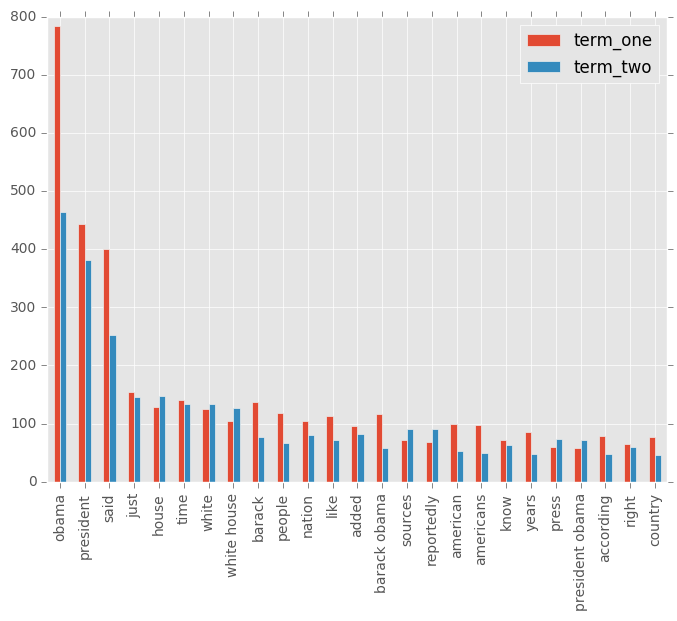

In [65]:
# plot 25 most used terms
word_counts.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(25).plot(kind='bar')

In [66]:
# make horizontal plots
def horizontal_plot(terms):
    ind = np.arange(len(word_counts.head(terms)))
    width = 0.4
    fig, ax = plt.subplots()
    
    # grab appropriate data
    term_one = word_counts.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(terms).values[:,0]
    term_two = word_counts.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(terms).values[:,1]
    ylabels = word_counts.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(terms).index
    
    # plot it
    ax.barh(ind, term_one, width, label='First Term Presidency', color='dodgerblue')
    ax.barh(ind + width, term_two, width, color='deepskyblue', label='Second Term Presidency')
    ax.set(yticks=ind + width, yticklabels=ylabels, ylim=[2*width - 1, len(word_counts.head(terms))])
    
    # fix axis, add details
    ax.legend(loc='lower right')
    plt.title("The Onion's %d Most Used Terms During Obama's Presidency"%terms, y=1.03, fontsize=14)
    plt.xlabel("Term (Word) Count")
    plt.gca().invert_yaxis()
    plt.savefig("./graphs/%d-most-used-terms-by-term.png"%terms, dpi=300, bbox_inches='tight')
    plt.show()

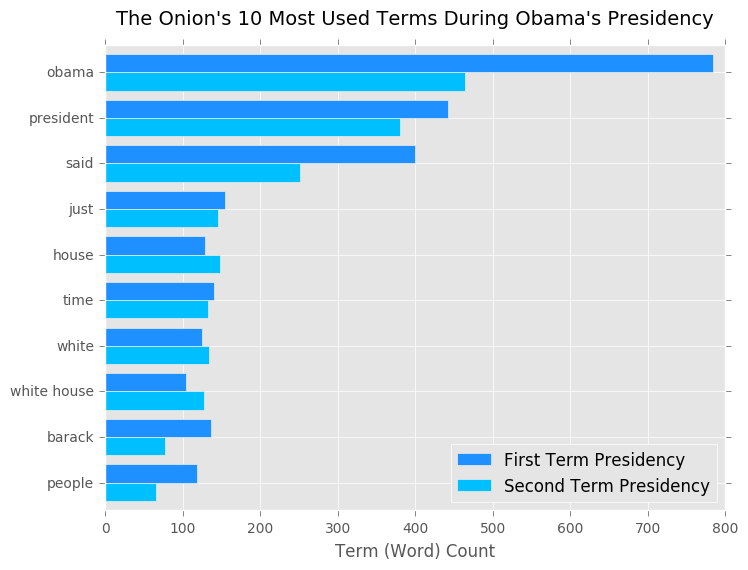

In [67]:
# top 10 words
horizontal_plot(10)

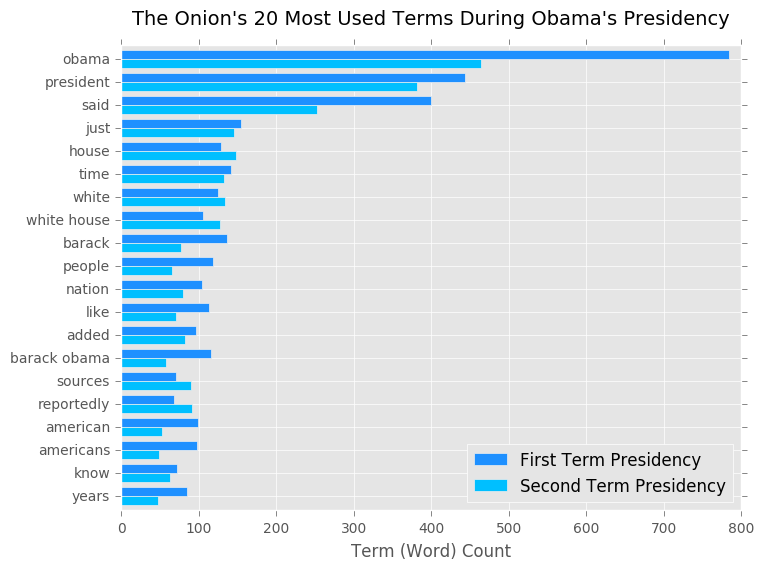

In [68]:
# top 20 words
horizontal_plot(20)

In [69]:
# Q: why are term_one counts so much higher? A: more words written during term one
print('Term one total word count ' + str(word_counts.term_one.sum()))
print('Term two total word count ' + str(word_counts.term_two.sum()))

Term one total word count 28384.0
Term two total word count 20944.0


### Use TF-IDF to investigate word importances

In [70]:
# repeat above, but for TF-IDF instead of CVEC
tfidf1 = pd.DataFrame(vect.fit_transform(obama_first.body).toarray(), columns=vect.get_feature_names())
tfidf2 = pd.DataFrame(vect.fit_transform(obama_second.body).toarray(), columns=vect.get_feature_names())
tfidf_scores = pd.merge(pd.DataFrame(data=tfidf1.sum().sort_values(ascending=False)),pd.DataFrame(data=tfidf2.sum().sort_values(ascending=False)),how='outer',left_index=True,right_index=True)
tfidf_scores.columns = ['term_one', 'term_two']
tfidf_scores['sum'] = tfidf_scores['term_one'] + tfidf_scores['term_two']
tfidf_scores.sort_values(['sum'], ascending=False)

,term_one,term_two,sum
obama,784.0,464.0,1248.0
president,443.0,381.0,824.0
said,400.0,252.0,652.0
just,155.0,146.0,301.0
house,129.0,148.0,277.0
time,141.0,133.0,274.0
white,125.0,134.0,259.0
white house,105.0,127.0,232.0
barack,137.0,77.0,214.0
people,118.0,66.0,184.0


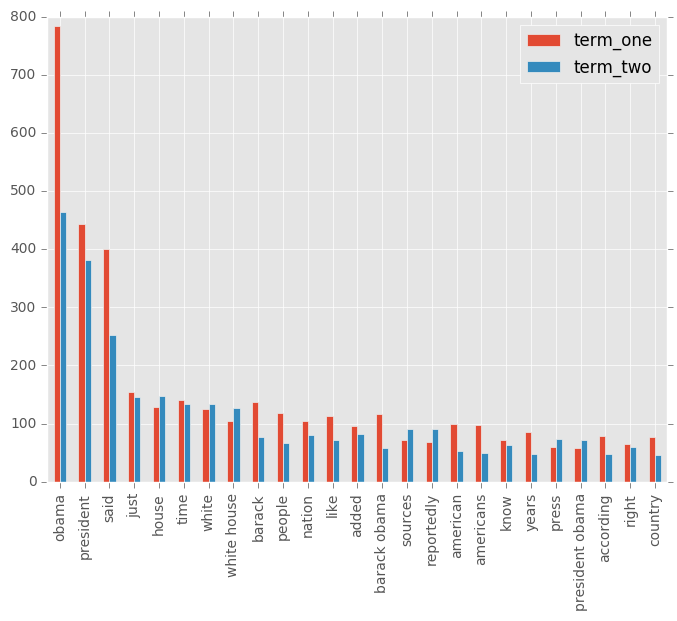

In [71]:
# plot 25 most used terms
tfidf_scores.sort_values(['sum'], ascending=False).drop('sum', axis=1).head(25).plot(kind='bar')

Nothing particularly different about using TF-IDF vs traditional word counts. Not too surprising.

In [72]:
# create a document-term matrix on whole dataset using TF-IDF
vect = TfidfVectorizer(stop_words='english')
dtm = vect.fit_transform(obama.body)
features = vect.get_feature_names()
dtm.shape

(262, 12008)

In [73]:
# use TF-IDF to summarize any story
def summarize():
    
    # choose a random review that is at least 300 characters
    story_length = 0
    while story_length < 300:
        story_id = np.random.randint(0, len(obama))
        story_text = unicode(obama.body[story_id], 'utf-8')
        story_length = len(story_text)
    
    # create a dictionary of words and their TF-IDF scores
    word_scores = {}
    for word in TextBlob(story_text).words:
        word = word.lower()
        if word in features:
            word_scores[word] = dtm[story_id, features.index(word)]
    
    # print words with the top 5 TF-IDF scores
    print 'TOP SCORING WORDS:'
    top_scores = sorted(word_scores.items(), key=lambda x: x[1], reverse=True)[:5]
    for word, score in top_scores:
        print word
    
    # print 5 random words
    print '\n' + 'RANDOM WORDS:'
    random_words = np.random.choice(word_scores.keys(), size=5, replace=False)
    for word in random_words:
        print word
    
    # print the review
    print '\n' + story_text

In [74]:
# for funsies
summarize()

TOP SCORING WORDS:
cavendish
fucking
tonight
greg
seat

RANDOM WORDS:
white
bad
say
government
invitees

While meeting with the official White House invitees to the State of the Union address ahead of tonight's speech, President Barack Obama reportedly shoved 39-year-old Tulsa-area auto parts store owner Jeff Cavendish into a seat in the Congressional gallery and told him to "just smile and keep [his] fucking mouth shut" for the duration of the night. "Listen, I'm going to mention your story, the camera's going to cut to you, Michelle will look your way and give you a supportive nod, and you just sit there with your goddamn trap closed and a big fucking happy grin across your fat face-you think you can handle that?" said Obama, jutting a finger into Cavendish's sternum and telling him that as long as he kept his ass in the seat and didn't make a goddamn peep, he couldn't fuck up too bad. "What's your name? Greg? Joe? Doesn't fucking matter. Tonight it's Greg. You have two kids-Hayley a

### Let's do some sentiment analysis.

In [75]:
# grab a story with Textblob
story = TextBlob(obama.body[0])

In [76]:
# polarity ranges from -1 (most negative) to 1 (most positive)
story.sentiment.polarity

0.07462256493506493

In [77]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    return TextBlob(text.decode('utf-8')).sentiment.polarity

In [78]:
# create a new DataFrame column for sentiment (can be slow!)
obama['sentiment'] = obama.body.apply(detect_sentiment)

In [79]:
obama.sentiment.describe()

count    262.000000
mean       0.083185
std        0.091416
min       -0.225980
25%        0.015366
50%        0.089412
75%        0.143657
max        0.323214
Name: sentiment, dtype: float64

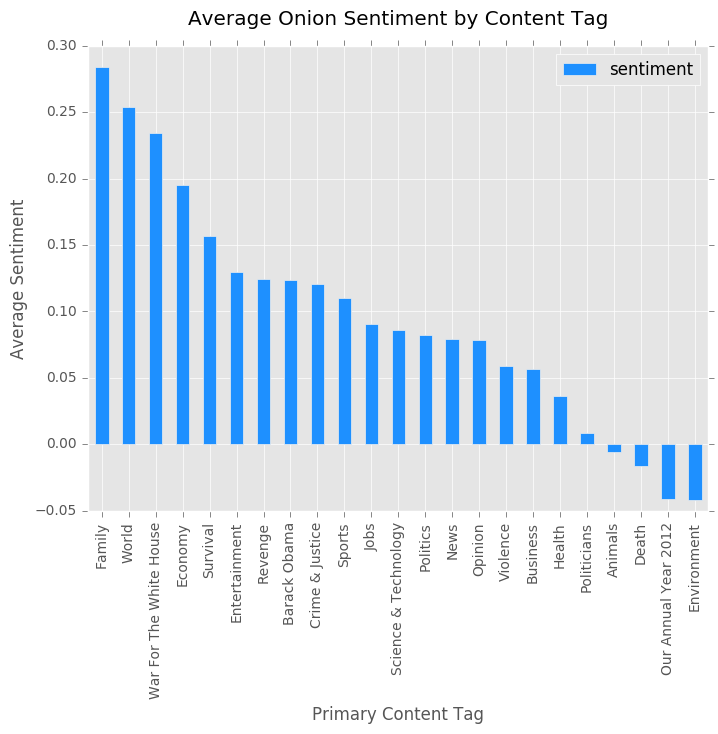

In [80]:
# plot sentiment
obama.groupby('tag0').mean().sort_values('sentiment', ascending=False).plot(kind='bar', color='dodgerblue')
plt.xlabel('Primary Content Tag')
plt.ylabel('Average Sentiment')
plt.title('Average Onion Sentiment by Content Tag', y=1.03)
plt.show()

In [81]:
# create Boolean filter for coloring
(obama.groupby('tag0').mean().sort_values('sentiment', ascending=False)>0).sentiment

tag0
Family                      True
World                       True
War For The White House     True
Economy                     True
Survival                    True
Entertainment               True
Revenge                     True
Barack Obama                True
Crime & Justice             True
Sports                      True
Jobs                        True
Science & Technology        True
Politics                    True
News                        True
Opinion                     True
Violence                    True
Business                    True
Health                      True
Politicians                 True
Animals                    False
Death                      False
Our Annual Year 2012       False
Environment                False
Name: sentiment, dtype: bool

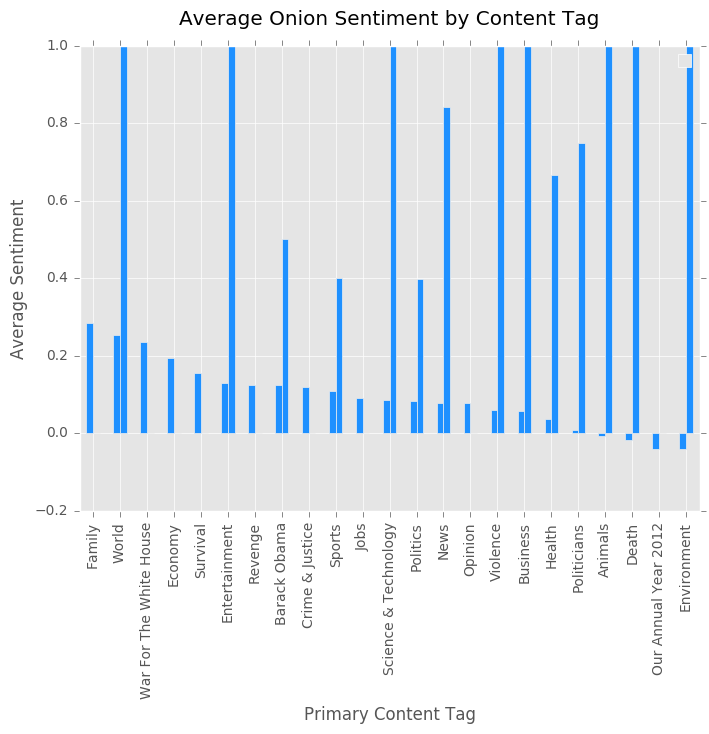

In [115]:
# plot sentiment, map colors to True/False based on blue/red filter above
sent_average = obama.groupby('tag0').mean().sort_values('sentiment', ascending=False).plot(kind='bar', color=(obama.groupby('tag0').mean().sort_values('sentiment', ascending=False)>0).sentiment.map({True: 'dodgerblue', False: 'orangered'}))
plt.xlabel('Primary Content Tag')
plt.ylabel('Average Sentiment')
plt.title('Average Onion Sentiment by Content Tag', y=1.03)
plt.legend('')
# plt.savefig("./graphs/sentiment-by-topic.png", dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# grab max story sentiment
print(str(len(obama[obama.sentiment > .32])) + ' story')
obama[obama.sentiment > .32].head(10)

1 story


,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location,sentiment
237,http://theonion.com/article/obama-praises-own-...,"Obama Praises Own Strength, Resilience In Face...",2016-01-12,Politics,Politicians,Barack Obama,NaN,NaN,Recounting in detail the numerous struggles an...,WASHINGTON,0.323214


<img src="story-screenshots/obama-positive.png">

[source](http://www.theonion.com/article/obama-praises-own-strength-resilience-face-hardshi-52152)

In [84]:
# grab min story sentiment
print(str(len(obama[obama.sentiment < -.22])) + ' story')
obama[obama.sentiment < -.22].head(10)

1 story


,link,title,date,tag0,tag1,tag2,tag3,tag4,body,location,sentiment
68,http://theonion.com/article/obama-returns-from...,Obama Returns From India With These Gross Cand...,2010-11-15,Politics,NaN,NaN,NaN,NaN,President Barack Obama returned from a recent ...,WASHINGTON,-0.22598


<img src="story-screenshots/obama-negative.png">

[source](http://www.theonion.com/article/obama-returns-from-india-with-these-gross-candies--18468)

In [85]:
# analyze sentiment over time
ts_sent = obama.set_index('date')

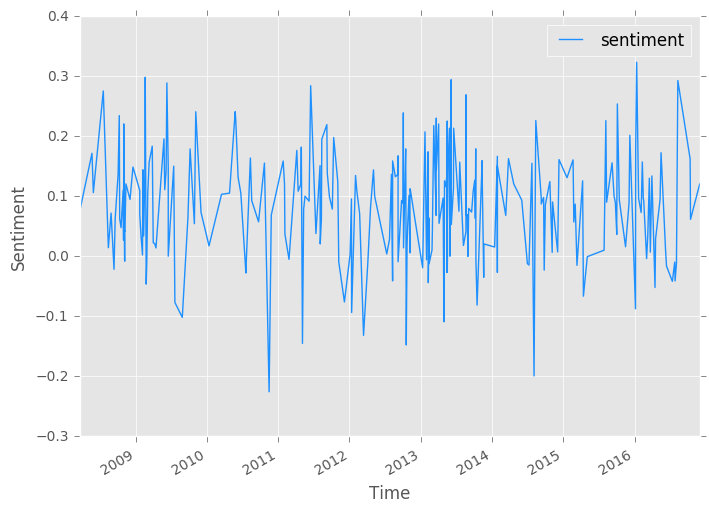

In [86]:
# plot it
ts_sent.plot(color='dodgerblue')
plt.xlabel('Time')
plt.ylabel('Sentiment')

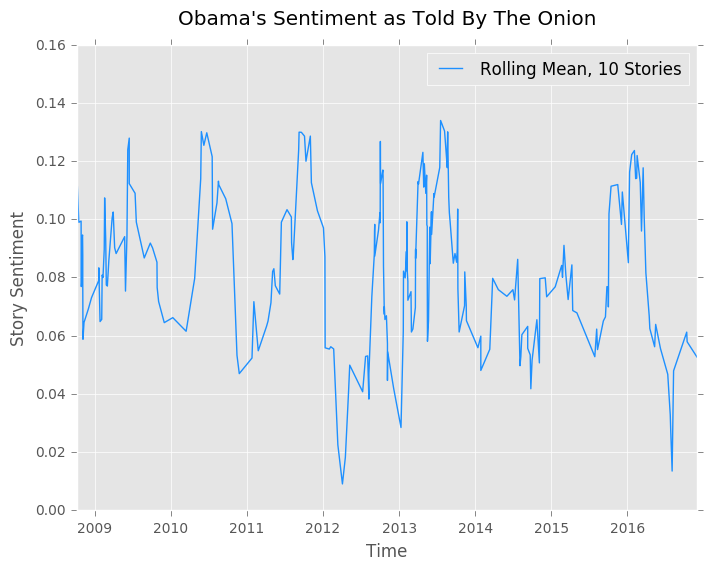

In [126]:
# let's plot a rolling mean instead; the above is too noisey
fig = plt.figure(figsize=(8, 6))
plt.plot(ts_sent.sentiment.rolling(window=10,center=False).mean(), label='Rolling Mean, 10 Stories', color='dodgerblue')
plt.legend(loc='best')
plt.title("Obama's Sentiment as Told By The Onion", y=1.03)
plt.ylabel('Story Sentiment')
plt.ylim(ymax=0.16)
plt.xlabel('Time')
plt.savefig("./graphs/sentiment-rolling-average.png", dpi=300, bbox_inches='tight')
plt.show()

In [88]:
# it appears a basketball story and White House hiring a jester story caused this early 2010 happy spike
ts_sent['2010']

,link,title,tag0,tag1,tag2,tag3,tag4,body,location,sentiment
date,,,,,,,,,,
2010-01-11,http://theonion.com/article/obama-to-wait-for-...,Obama To Wait For Next Bruce Springsteen Album...,Politics,Economy,Music,Barack Obama,Recession,Faced with the worst economic crisis since the...,WASHINGTON,0.017199
2010-03-16,http://theonion.com/article/obama-visits-kinde...,Obama Visits Kindergarten To Read Class 200-Pa...,Politics,Healthcare,Barack Obama,NaN,NaN,As part of a new program designed to encourage...,MIAMI,0.103154
2010-04-26,http://theonion.com/article/obama-promoted-to-...,Obama Promoted To Senior Vice President Of Ame...,Politics,Barack Obama,NaN,NaN,NaN,A statement from America's National Headquarte...,NEW YORK,0.105072
2010-05-25,http://theonion.com/article/white-house-jester...,White House Jester Beheaded For Making Fun Of ...,Politics,Economy,NaN,NaN,NaN,"After serving 12 years in the position, Motley...",WASHINGTON,0.240858
2010-05-28,http://theonion.com/article/president-obama-me...,President Obama Mentions He'd Like To See LeBr...,Sports,Basketball,Barack Obama,Sports Year In Review 2010,NaN,"President of the United States, basketball fan...",WASHINGTON,0.227054
2010-06-09,http://theonion.com/article/obama-to-make-reas...,Obama To Make Reassuring Eye Contact With Ever...,Politics,Barack Obama,NaN,NaN,NaN,In an attempt to convince an anxious populace ...,"ROCKLAND, ME",0.131454
2010-06-23,http://theonion.com/article/obamas-weekly-vide...,Obama's Weekly Video Addresses Becoming Increa...,Politics,Barack Obama,NaN,NaN,NaN,Hailed as a sign of renewed government transpa...,WASHINGTON,0.105066
2010-07-19,http://theonion.com/article/obamas-fifth-gulf-...,Obama's Fifth Gulf Coast Visit Really Helps A ...,Politics,Barack Obama,NaN,NaN,NaN,Critics were silenced today after President Ba...,NEW ORLEANS,-0.028041
2010-07-21,http://theonion.com/article/local-family-homel...,Local Family Homeless After Tornado Destroys W...,Politics,Natural Disasters,Barack Obama,NaN,NaN,Barack Obama stands alone in the ruins of what...,WASHINGTON,-0.008826


In [89]:
# not a persistent theme keeping this negative: basketball, speech gaffe, healthcare
ts_sent['2011-08-01':'2012']

,link,title,tag0,tag1,tag2,tag3,tag4,body,location,sentiment
date,,,,,,,,,,
2011-08-03,http://theonion.com/article/obama-debt-ceiling...,Obama: Debt Ceiling Deal Required Tough Conces...,Politics,Barack Obama,NaN,NaN,NaN,A day after signing legislation that raised th...,WASHINGTON,0.150926
2011-08-04,http://theonion.com/article/obama-turns-50-des...,Obama Turns 50 Despite Republican Opposition\n,Politics,Our Annual Year 2011,NaN,NaN,NaN,After months of heated negotiations and failed...,WASHINGTON,0.020408
2011-08-10,http://theonion.com/article/new-gop-strategy-i...,"New GOP Strategy Involves Reelecting Obama, Ma...",Politics,NaN,NaN,NaN,NaN,Calling a GOP victory in the 2012 presidential...,WASHINGTON,0.061862
2011-08-12,http://theonion.com/article/obama-proposes-tax...,Obama Proposes Tax Increase On Meanest 2% Of P...,Economy,NaN,NaN,NaN,NaN,In the latest administration initiative meant ...,WASHINGTON,0.194949
2011-09-07,http://theonion.com/article/obama-earns-money-...,Obama Earns Money For U.S. By Appearing In Jap...,Barack Obama,Our Annual Year 2011,NaN,NaN,NaN,In an effort to obtain badly needed revenue fo...,WASHINGTON,0.219320
2011-09-09,http://theonion.com/article/house-condescendin...,House Condescendingly Approves $400 In Added S...,Politics,Our Annual Year 2011,NaN,NaN,NaN,Following President Obama's speech on the stat...,WASHINGTON,0.138799
2011-09-20,http://theonion.com/article/obama-visits-south...,Obama Visits South-Carolina-Ravaged South Caro...,Politics,Barack Obama,NaN,NaN,NaN,"Calling the devastation ""heartbreaking and app...","COLUMBIA, SC",0.099495
2011-10-05,http://theonion.com/article/obama-not-sure-how...,Obama Not Sure How To Handle Compliment\n,Politics,Barack Obama,NaN,NaN,NaN,During an appearance at a town hall meeting Mo...,"GRAND RAPIDS, MI",0.078526
2011-10-12,http://theonion.com/article/obama-seeks-approv...,Obama Seeks Approval Of 'Occupy Wall Street' P...,Politics,Barack Obama,Ifc,NaN,NaN,[Early Polls Indicate 44% of Respondents Sayin...,NaN,0.197869


## Build a model to determine if a story was first or second term

In [90]:
# list comprehension to make 0 for first term, 1 for second term
obama['second_term'] = [1 if datetime.date(obama.date[i].year, obama.date[i].month, obama.date[i].day) >= datetime.date(2013, 1, 20) else 0 for i,x in enumerate(obama.date)]

In [91]:
# verify list comprehension success
obama.second_term.value_counts()

0    134
1    128
Name: second_term, dtype: int64

In [92]:
# average story length per term? (revisted from above CVEC curiosity)
print('Term one average story length: '+ str(word_counts.term_one.sum()/obama.second_term.value_counts()[0]))
print('Term two average story length: '+ str(word_counts.term_two.sum()/obama.second_term.value_counts()[1]))

Term one average story length: 211.820895522
Term two average story length: 163.625


In [93]:
# define X and y
X = obama.body
y = obama.second_term

# split the new DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [94]:
# vectorizer used earlier with blue graphs - simple counts
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english', min_df=2)

In [95]:
# use vectorizer created above to create document-term matrices from X_train and X_test
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

### Naive Bayes

For an introduction to Naive Bayes and text data, check out [Sebastian Rashcka](http://sebastianraschka.com/Articles/2014_naive_bayes_1.html)

In [96]:
# use Naive Bayes to predict term
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

# calculate accuracy
print metrics.accuracy_score(y_test, y_pred_class)

0.727272727273


In [97]:
# calculate null accuracy
y_test_binary = np.where(y_test==0, 1, 0)
max(y_test_binary.mean(), 1 - y_test_binary.mean())

0.53030303030303028

**A 20% lift vs null accuracy isn't too bad!**

### Support Vector Machine

Support vector machines work well on text data becuase:
- Reduces risk of overfitting in high dimension input space
- Similarly, trains on few irrelevant features
- Document vectors are sparse
- Our text categorization problem is linearly separable

More info on a paper (Joachims, 1998) cited 8000+ times on this is [here](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf).

For a tutorial on SVMs, check [svm-tutorial.com](http://www.svm-tutorial.com/2014/11/svm-understanding-math-part-1/)

In [98]:
# SUPER SLOWLY and lazily going to check every parameter for an SVM on my text data
clf = svm.SVC()
gamma_range = 10.**np.arange(-5, 2)
C_range = 10.**np.arange(-2, 3)
kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']
param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_dtm, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kernel': ['rbf', 'sigmoid', 'linear', 'poly'], 'C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02]), 'gamma': array([  1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [99]:
# what was best?
print grid.best_score_
print grid.best_params_
print grid.best_estimator_

0.739795918367
{'kernel': 'linear', 'C': 0.01, 'gamma': 1.0000000000000001e-05}
SVC(C=0.01, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=1.0000000000000001e-05,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


Even after all of that SVM training, we improved over Naive Bayes by like 2%. But hey...
**A 20% lift vs null accuracy isn't too bad!**

### Random Forest

Given the high dimensions of our features (very wide compared to long), a random forest will likely be quite poor.

However, random forests enable us to easily identify various feature importances. In this case, we will be able to see which words are most dilenating between Obama's first and second terms in The Onion's coverage.

In [100]:
from sklearn.ensemble import RandomForestClassifier
rf_grid = RandomForestClassifier(random_state=99, n_jobs=50)

In [101]:
#Parameter dictionary of settings options for the model we're passing grid search.
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [None,2,5,8],
    'max_features' : ['auto', 'sqrt', 'log2'],
    'class_weight' : ['balanced', None]
}

In [102]:
#Instantiate grid search.
grid = GridSearchCV(rf_grid, param_grid, cv=5, scoring='accuracy')

#Fit the grid search to X, and y.
grid.fit(X_train_dtm, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=50,
            oob_score=False, random_state=99, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 2, 5, 8], 'class_weight': ['balanced', None]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [103]:
#Store the best parameters in a variable.
params = grid.best_params_
print "Best score =", grid.best_score_
print params

Best score = 0.642857142857
{'max_features': 'auto', 'criterion': 'entropy', 'max_depth': None, 'class_weight': None}


In [104]:
#Run Random Forest on the data.
rf = RandomForestClassifier(**params)
rf_model = rf.fit(X_train_dtm, y_train)
y_pred = rf.predict(X_test_dtm)

print "RandomForest Cross_Val Score:\t", cross_val_score(rf, X_train_dtm, y_train, cv=5).mean()
print "Train/Test RandomForest Score:\t", rf.score(X_test_dtm, y_test)

RandomForest Cross_Val Score:	0.652975708502
Train/Test RandomForest Score:	0.606060606061


Indeed, a random forest is not the best choice.

In [105]:
# create dataframe showing feature importances of rf
df_features = pd.DataFrame(columns=['Features', 'Importance (Gini Index)'])
df_features['Features'] = columns=vect.get_feature_names()
df_features['Importance (Gini Index)'] = rf.feature_importances_
df_features.sort_values('Importance (Gini Index)', ascending=False, inplace=True)

In [106]:
# top 10 features
df_features.head(15)

,Features,Importance (Gini Index)
856,candidate,0.022966
4016,press time,0.016160
3398,new,0.012226
1294,crisis,0.009686
1683,election,0.009619
4353,republicans,0.008936
1,000,0.008365
3196,michelle,0.007892
3919,positions,0.007732
5704,white house,0.007412


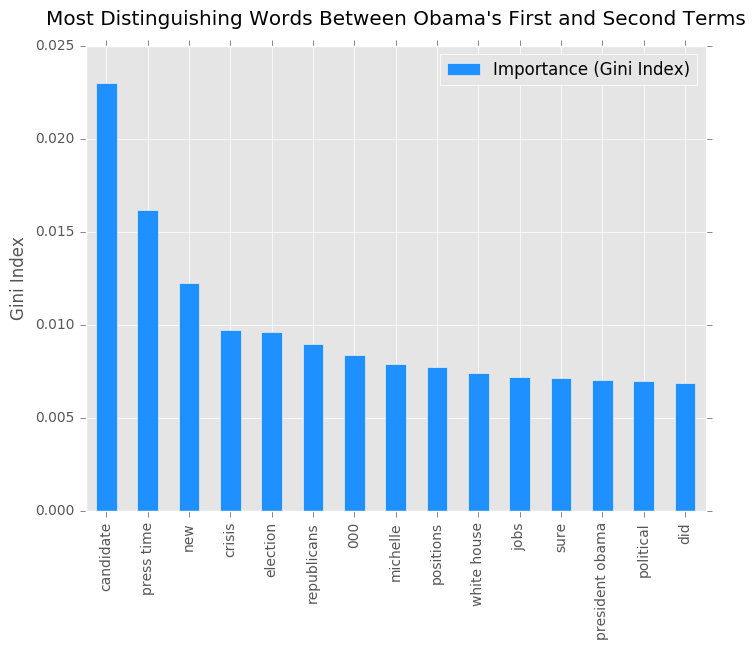

In [107]:
# plot most important features
df_features.head(15).plot(kind='bar', x='Features', color='dodgerblue')
plt.ylabel('Gini Index')
plt.xlabel('')
plt.title("Most Distinguishing Words Between Obama's First and Second Terms", y=1.03)
plt.savefig("./graphs/rf-feature-importance.png", dpi=300, bbox_inches='tight')

### Try playing with different vectorizers using Naive Bayes to improve accuracy:

In [108]:
# define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test(vect):
    X_train_dtm = vect.fit_transform(X_train)
    print 'Features: ', X_train_dtm.shape[1]
    X_test_dtm = vect.transform(X_test)
    nb = MultinomialNB()
    nb.fit(X_train_dtm, y_train)
    y_pred_class = nb.predict(X_test_dtm)
    print 'Accuracy: ', metrics.accuracy_score(y_test, y_pred_class)

In [109]:
# include 1-grams and 2-grams
vect = CountVectorizer(ngram_range=(1, 2))
tokenize_test(vect)

Features:  58752
Accuracy:  0.787878787879


In [110]:
# remove English stop words
vect = CountVectorizer(ngram_range=(1, 2), stop_words='english')
tokenize_test(vect)

Features:  44970
Accuracy:  0.80303030303


**High score!**

Final results suggest the most powerful model is a Naive Bayes classifier with an ngram range of 1 to 2 and English stopword removal. This model achieved a ~30% lift over the null accuracy: 80% vs 53%.

In [111]:
# dig deeper: confusion matrix 
conmat = np.array(confusion_matrix(y_test, y_pred_class, labels=[1,0]))
confusion = pd.DataFrame(conmat, index=['term_two', 'term_one'],
                         columns=['predicted_term_two','predicted_term_one'])
print(confusion)

          predicted_term_two  predicted_term_one
term_two                  23                   8
term_one                  10                  25


Based on the confusion matrix, false positives (predicted an article was from the second term but it was actually from the first term) and false negatives (predicted an article was from the first term, but it was actually from the second term) are relatively controlled. I am indifferent to minimizing type one error vs type two error in this case, so aiming for highest accuracy regardless of error type is satisfactory.